In [112]:
import pandas as pd
import pycountry 
import time
import re
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc 

<h1><center> Cleanning : 

In [113]:
df = pd.read_csv('opportunites_demploi.csv', encoding='iso-8859-1')

In [114]:
df.head()

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,"
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,Entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,"
2,Cricut,Machine Learning Engineer,"South Jordan, UT, United States",Full Time,NaN,90K+ *,"Agile,Architecture,AWS,Computer Science,Comput...","Career development,,,,"
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,Entry-level,48K+ *,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,"
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,Mid-level,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi..."


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Company                     3197 non-null   object
 1   Job Title                   3197 non-null   object
 2   Location                    3197 non-null   object
 3   Job Type                    3197 non-null   object
 4   Experience level            2962 non-null   object
 5   Salary                      3009 non-null   object
 6   Requirment of the company   3198 non-null   object
 7   Facilities                  3198 non-null   object
dtypes: object(8)
memory usage: 200.0+ KB


In [116]:
df.duplicated().sum()

202

In [117]:
df.drop_duplicates(inplace=True)

In [118]:
df.isna().sum()

Company                         1
Job Title                       1
Location                        1
Job Type                        1
Experience level              228
Salary                        172
Requirment of the company       0
Facilities                      0
dtype: int64

In [119]:
# change the valeure monquante :
df['Experience level'].fillna('Not-Specified', inplace=True)
df = df[df['Salary']!= 0]

In [120]:
df.dropna(inplace=True)

In [121]:
# to lower case :
df['Job Title'] = df['Job Title'].str.lower()
df['Location'] = df['Location'].str.lower()
df['Requirment of the company '] = df['Requirment of the company '].str.lower()

#### Salary :

In [122]:
import re

def convert_to_dig(txt):
    if txt != 0  :
        power = 1
        if 'GBP' in txt:
            power *= 1.29
        if 'EUR' in txt:
            power *= 1.16
        # Extract the number using regex and convert it to an integer
        num_str = re.sub(r'[^\d]', '', txt)
        num = int(num_str) if num_str.isdigit() else 0
        
        return num * 1000 * power
    else :
        return txt


In [123]:
# add the minument salary column :
df['AVG_Salary'] =  df['Salary'].apply(convert_to_dig)

In [124]:
# add negosiation column : 
def detect_neg(txt) :
    if type(txt) != int :
        if '+' in txt :
            return True
        else :
            return False
        return False

df['Negotiation'] = df['Salary'].apply(detect_neg)
df['Negotiation']

0       True
1       True
2       True
3       True
4       True
        ... 
3190    True
3191    True
3192    True
3193    True
3196    True
Name: Negotiation, Length: 2824, dtype: bool

In [125]:
# Ajouter salary asterisk :
asterisk = lambda salary: True if salary != 0 and '*' in salary else False

df['asterisk'] = df['Salary'].apply(asterisk)

In [126]:
df = df.drop(columns = ['Salary'])

#### Requirment of the company :

In [127]:
# change column to list :
df['Requirment of the company '] = df['Requirment of the company '].str.split(',')

#### Location :

In [128]:
country_list = ['Afghanistan', 'Aland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia, Plurinational State of', 'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil', 'British Indian Ocean Territory', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia', 'Comoros', 'Congo', 'Congo, The Democratic Republic of the', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Heard Island and McDonald Islands', 'Holy See (Vatican City State)', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran, Islamic Republic of', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', "Korea, Democratic People's Republic of", 'Korea, Republic of', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macao', 'Macedonia, Republic of', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Martinique', 'Mauritania', 'Mauritius', 'Mayotte', 'Mexico', 'Micronesia, Federated States of', 'Moldova, Republic of', 'Monaco', 'Mongolia', 'Montenegro', 'Montserrat', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Caledonia', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Palestinian Territory, Occupied', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Pitcairn', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Réunion', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin (French part)', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Sint Maarten (Dutch part)', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Georgia and the South Sandwich Islands', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'South Sudan', 'Svalbard and Jan Mayen', 'Swaziland', 'Sweden', 'Switzerland', 'Syrian Arab Republic', 'Taiwan, Province of China', 'Tajikistan', 'Tanzania, United Republic of', 'Thailand', 'Timor-Leste', 'Togo', 'Tokelau', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'United States Minor Outlying Islands', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela, Bolivarian Republic of', 'Viet Nam', 'Virgin Islands, British', 'Virgin Islands, U.S.', 'Wallis and Futuna', 'Yemen', 'Zambia', 'Zimbabwe']
country_list = [country.lower() for country in country_list]

country_code = {"AF":"Afghanistan",
"AX":"Aland Islands",
"AL":"Albania",
"DZ":"Algeria",
"AS":"American Samoa",
"AD":"Andorra",
"AO":"Angola",
"AI":"Anguilla",
"AQ":"Antarctica",
"AG":"Antigua and Barbuda",
"AR":"Argentina",
"AM":"Armenia",
"AW":"Aruba",
"AU":"Australia",
"AT":"Austria",
"AZ":"Azerbaijan",
"BS":"Bahamas",
"BH":"Bahrain",
"BD":"Bangladesh",
"BB":"Barbados",
"BY":"Belarus",
"BE":"Belgium",
"BZ":"Belize",
"BJ":"Benin",
"BM":"Bermuda",
"BT":"Bhutan",
"BO":"Bolivia, Plurinational State of",
"BQ":"Bonaire, Sint Eustatius and Saba",
"BA":"Bosnia and Herzegovina",
"BW":"Botswana",
"BV":"Bouvet Island",
"BR":"Brazil",
"IO":"British Indian Ocean Territory",
"BN":"Brunei Darussalam",
"BG":"Bulgaria",
"BF":"Burkina Faso",
"BI":"Burundi",
"KH":"Cambodia",
"CM":"Cameroon",
"CA":"Canada",
"CV":"Cape Verde",
"KY":"Cayman Islands",
"CF":"Central African Republic",
"TD":"Chad",
"CL":"Chile",
"CN":"China",
"CX":"Christmas Island",
"CC":"Cocos (Keeling) Islands",
"CO":"Colombia",
"KM":"Comoros",
"CG":"Congo",
"CD":"Congo, The Democratic Republic of the",
"CK":"Cook Islands",
"CR":"Costa Rica",
"CI":"Côte d'Ivoire",
"HR":"Croatia",
"CU":"Cuba",
"CW":"Curaçao",
"CY":"Cyprus",
"CZ":"Czech Republic",
"DK":"Denmark",
"DJ":"Djibouti",
"DM":"Dominica",
"DO":"Dominican Republic",
"EC":"Ecuador",
"EG":"Egypt",
"SV":"El Salvador",
"GQ":"Equatorial Guinea",
"ER":"Eritrea",
"EE":"Estonia",
"ET":"Ethiopia",
"FK":"Falkland Islands (Malvinas)",
"FO":"Faroe Islands",
"FJ":"Fiji",
"FI":"Finland",
"FR":"France",
"GF":"French Guiana",
"PF":"French Polynesia",
"TF":"French Southern Territories",
"GA":"Gabon",
"GM":"Gambia",
"GE":"Georgia",
"DE":"Germany",
"GH":"Ghana",
"GI":"Gibraltar",
"GR":"Greece",
"GL":"Greenland",
"GD":"Grenada",
"GP":"Guadeloupe",
"GU":"Guam",
"GT":"Guatemala",
"GG":"Guernsey",
"GN":"Guinea",
"GW":"Guinea-Bissau",
"GY":"Guyana",
"HT":"Haiti",
"HM":"Heard Island and McDonald Islands",
"VA":"Holy See (Vatican City State)",
"HN":"Honduras",
"HK":"Hong Kong",
"HU":"Hungary",
"IS":"Iceland",
"IN":"India",
"ID":"Indonesia",
"IR":"Iran, Islamic Republic of",
"IQ":"Iraq",
"IE":"Ireland",
"IM":"Isle of Man",
"IL":"Israel",
"IT":"Italy",
"JM":"Jamaica",
"JP":"Japan",
"JE":"Jersey",
"JO":"Jordan",
"KZ":"Kazakhstan",
"KE":"Kenya",
"KI":"Kiribati",
"KP":"Korea, Democratic People's Republic of",
"KR":"Korea, Republic of",
"KW":"Kuwait",
"KG":"Kyrgyzstan",
"LA":"Lao People's Democratic Republic",
"LV":"Latvia",
"LB":"Lebanon",
"LS":"Lesotho",
"LR":"Liberia",
"LY":"Libya",
"LI":"Liechtenstein",
"LT":"Lithuania",
"LU":"Luxembourg",
"MO":"Macao",
"MK":"Macedonia, Republic of",
"MG":"Madagascar",
"MW":"Malawi",
"MY":"Malaysia",
"MV":"Maldives",
"ML":"Mali",
"MT":"Malta",
"MH":"Marshall Islands",
"MQ":"Martinique",
"MR":"Mauritania",
"MU":"Mauritius",
"YT":"Mayotte",
"MX":"Mexico",
"FM":"Micronesia, Federated States of",
"MD":"Moldova, Republic of",
"MC":"Monaco",
"MN":"Mongolia",
"ME":"Montenegro",
"MS":"Montserrat",
"MA":"Morocco",
"MZ":"Mozambique",
"MM":"Myanmar",
"NA":"Namibia",
"NR":"Nauru",
"NP":"Nepal",
"NL":"Netherlands",
"NC":"New Caledonia",
"NZ":"New Zealand",
"NI":"Nicaragua",
"NE":"Niger",
"NG":"Nigeria",
"NU":"Niue",
"NF":"Norfolk Island",
"MP":"Northern Mariana Islands",
"NO":"Norway",
"OM":"Oman",
"PK":"Pakistan",
"PW":"Palau",
"PS":"Palestinian Territory, Occupied",
"PA":"Panama",
"PG":"Papua New Guinea",
"PY":"Paraguay",
"PE":"Peru",
"PH":"Philippines",
"PN":"Pitcairn",
"PL":"Poland",
"PT":"Portugal",
"PR":"Puerto Rico",
"QA":"Qatar",
"RE":"Réunion",
"RO":"Romania",
"RU":"Russian Federation",
"RW":"Rwanda",
"BL":"Saint Barthélemy",
"SH":"Saint Helena, Ascension and Tristan da Cunha",
"KN":"Saint Kitts and Nevis",
"LC":"Saint Lucia",
"MF":"Saint Martin (French part)",
"PM":"Saint Pierre and Miquelon",
"VC":"Saint Vincent and the Grenadines",
"WS":"Samoa",
"SM":"San Marino",
"ST":"Sao Tome and Principe",
"SA":"Saudi Arabia",
"SN":"Senegal",
"RS":"Serbia",
"SC":"Seychelles",
"SL":"Sierra Leone",
"SG":"Singapore",
"SX":"Sint Maarten (Dutch part)",
"SK":"Slovakia",
"SI":"Slovenia",
"SB":"Solomon Islands",
"SO":"Somalia",
"ZA":"South Africa",
"GS":"South Georgia and the South Sandwich Islands",
"ES":"Spain",
"LK":"Sri Lanka",
"SD":"Sudan",
"SR":"Suriname",
"SS":"South Sudan",
"SJ":"Svalbard and Jan Mayen",
"SZ":"Swaziland",
"SE":"Sweden",
"CH":"Switzerland",
"SY":"Syrian Arab Republic",
"TW":"Taiwan, Province of China",
"TJ":"Tajikistan",
"TZ":"Tanzania, United Republic of",
"TH":"Thailand",
"TL":"Timor-Leste",
"TG":"Togo",
"TK":"Tokelau",
"TO":"Tonga",
"TT":"Trinidad and Tobago",
"TN":"Tunisia",
"TR":"Turkey",
"TM":"Turkmenistan",
"TC":"Turks and Caicos Islands",
"TV":"Tuvalu",
"UG":"Uganda",
"UA":"Ukraine",
"AE":"United Arab Emirates",
"GB":"United Kingdom",
"US":"United States",
"UM":"United States Minor Outlying Islands",
"UY":"Uruguay",
"UZ":"Uzbekistan",
"VU":"Vanuatu",
"VE":"Venezuela, Bolivarian Republic of",
"VN":"Viet Nam",
"VG":"Virgin Islands, British",
"VI":"Virgin Islands, U.S.",
"WF":"Wallis and Futuna",
"YE":"Yemen",
"ZM":"Zambia",
"ZW":"Zimbabwe"}

In [129]:
# Clean and normalize columns location function : :
def fixi_Location(input_string):

    input_string = str(input_string)
    hyphen_pattern = r"-"
    # Use re.sub() to replace hyphens with commas
    replaced_string = re.sub(hyphen_pattern, ",", input_string)
    # Define the regular expression pattern to match numbers and special characters
    pattern = r"[^a-zA-Z, -]"
    
    # Use re.sub() to replace matched characters with an empty string
    cleaned_string = re.sub(pattern, "", replaced_string)
    cleaned_string = cleaned_string.split(',')
    cleaned_string = [item.strip() for item in cleaned_string if item.strip()]
    return cleaned_string    


In [130]:
df['Location'] = df['Location'].apply(fixi_Location)

In [131]:
# show how to look :
locition = df['Location'].tolist()
for i in locition :
    print(fixi_Location(i))

['richardson', 'tx', 'united states']
['ebne', 'mauritius']
['south jordan', 'ut', 'united states']
['nonantola', 'italy']
['arlington', 'va', 'united states']
['kirkland', 'washington', 'united states']
['porto', 'portugal']
['santa clara', 'ca', 'united states']
['geneva', 'switzerland']
['toronto', 'on', 'canada']
['mumbai', 'india']
['braga', 'portugal']
['gerlingen', 'germany']
['kirkland', 'washington', 'united states']
['united states', 'aliso viejo', 'ca']
['sydney', 'new south wales', 'australia']
['braga']
['remote job']
['tallinn']
['bengaluru', 'india']
['mlaga', 'spain']
['plymouth', 'mi', 'united states']
['remote worldwide']
['houston', 'tx', 'united states']
['saint', 'herblain', 'france']
['new york city', 'united states']
['mexico city', 'mexico']
['so paulo', 'state of so paulo', 'brazil']
['poland or eastern europe remote']
['batu kawan', 'malaysia']
['lehi', 'utah', 'open to remote']
['barcelona', 'spain']
['los angeles', 'ca']
['wroclaw', 'pl']
['mount prospect', 

In [132]:
# function to find country :

def get_country(list_adress) :
    for i in list_adress :
        i = i.lower()
        if i in country_list :
            return i
        
    for i in list_adress :
        if i.upper() in country_code :
            return country_code[i.upper()]
    for i in list_adress :
        if 'remote' in i :
            return 'remote'
        
    for i in list_adress :
        # find with alpha_3 :
        country_alpha3 = pycountry.countries.get(alpha_3=i)
        if country_alpha3 :
            return country_alpha3.name
        
    for i in list_adress :
        # find country by city :
        geolocator = Nominatim(user_agent="city_country_app")
        try:
            location = geolocator.geocode(i, language="en", timeout=10)
            if location:
                return location.address.split(",")[-1].strip()
        except GeocoderTimedOut :
            # Retry after a short delay.
            time.sleep(5)
            continue

    return list_adress

get_country(['redmote','bidan','cadd','phidlippines','usba'])

'Iraq'

In [133]:
df['Country'] = df['Location'].apply(get_country)

In [134]:
df['Country'] = df['Country'].str.lower()

In [135]:
for i in df['Country'].tolist() :
    print(i)

united states
mauritius
united states
italy
united states
united states
portugal
united states
switzerland
canada
india
portugal
germany
united states
united states
australia
portugal
remote
estonia
india
spain
united states
remote
united states
france
united states
mexico
brazil
remote
malaysia
remote
spain
canada
poland
united states
argentina
united states
india
germany
argentina
united states
remote
united states
remote
belgium
india
remote
united states
remote
canada
united states
united kingdom
remote
brazil
united kingdom
united states
united states
mauritius
united states
united states
india
remote
ukraine
united states
united kingdom
canada
united states
united kingdom
united states
united states
canada
united arab emirates
australia
united states
united states
germany
canada
south africa
costa rica
united states
united kingdom
united states
united states
costa rica
canada
france
united states
united states
belgium
canada
united kingdom
belgium
united states
united states
remo

#### Job Title	:

In [136]:
df

,Company,Job Title,Location,Job Type,Experience level,Requirment of the company,Facilities,AVG_Salary,Negotiation,asterisk,Country
0,SGS,clinical data analyst,"[richardson, tx, united states]",Full Time,Entry-level,"[computer science, data quality, genetics, mat...",",,,,",48000.0,True,True,united states
1,Ocorian,aml/cft & data analyst,"[ebne, mauritius]",Full Time,Entry-level,"[agile, data management, finance, security, , ]",",,,,",48000.0,True,True,mauritius
2,Cricut,machine learning engineer,"[south jordan, ut, united states]",Full Time,Not-Specified,"[agile, architecture, aws, computer science, c...","Career development,,,,",90000.0,True,True,united states
3,Bosch Group,application developer & data analyst,"[nonantola, italy]",Full Time,Entry-level,"[engineering, industrial, oracle, power bi, r,...",",,,,",48000.0,True,True,italy
4,Publicis Groupe,data engineer full time (public sector) usa,"[arlington, va, united states]",Full Time,Mid-level,"[aws, azure, computer science, consulting, dat...","Flex hours,Flex vacation,Parental leave,Unlimi...",108000.0,True,False,united states
...,...,...,...,...,...,...,...,...,...,...,...
3190,CCRi,"application integration engineer, computer vis...","[chantilly, virginia, united states]",Full Time,Mid-level,"[agile, angular, apis, architecture, aws, azure]","401(k) matching,Career development,Flex hours,...",113000.0,True,False,united states
3191,Publicis Groupe,"associate director, data science","[new york city, united states]",Full Time,Mid-level,"[bayesian, classification, clustering, data an...","Career development,Health care,,,",106000.0,True,False,united states
3192,DoorDash,"senior software engineer, machine learning - a...","[sunnyvale, ca san francisco, ca new york]",Full Time,Senior-level,"[computer science, data analysis, engineering,...","401(k) matching,Career development,Equity,Insu...",176000.0,True,False,united states
3193,Western Digital,data scientist - new college graduate,"[bian, philippines]",Full Time,Entry-level,"[apis, clustering, computer science, data visu...","Career development,,,,",39000.0,True,True,philippines


In [137]:
list_job = df['Job Title'].value_counts().index.tolist()
len(list_job)

2008

In [138]:
# my origine code :
def find_job_role(job_title) :

    job_rool = {
        'IA' : ['ai','artificial','intelligence','ml','machine','learning'],
        'data scientist' : ['data','scientist','scient','science'],
        'big data' : ['big data','big','bi'],
        'data Analyste' : ['analyst','data','analytics'],
        'data engineer' : ['data','engineer']
    }

    a,b,c,d,e = 0,0,0,0,0

    for sub_ia in job_rool['IA'] :
        if sub_ia in job_title :
            a +=1

    for sub_scin in job_rool['data scientist'] :
        if sub_scin in job_title :
            b +=1

    for sub_bd in job_rool['big data'] :
        if sub_bd in job_title :
            c +=1

    for sub_DA in job_rool['data Analyste'] :
        if sub_DA in job_title :
            d +=1

    for sub_DE in job_rool['data engineer'] :
        if sub_DE in job_title :
            e +=1

    max = sorted([a,b,c,d,e], reverse=True)

    if sum(max) != 0 :
    
        if a == max[0]  :
            return 'IA'
        
        if b == max[0] :
            return 'data scientist'
        
        if c == max[0] :
            return 'big data'
        
        if d == max[0] :
            return 'data Analyste'

        if e == max[0] :
            return 'data engineer'
    return 'other'

find_job_role('data engineer')

'data engineer'

In [139]:
# function rusumer :
def find_job_role(job_title):
    job_roles = {
        'IA': ['ai', 'artificial', 'intelligence', 'ml', 'machine', 'learning'],
        'data scientist': ['data', 'scientist', 'scient', 'science'],
        'big data': ['big data', 'big', 'bi'],
        'data Analyste': ['analyst', 'data', 'analytics'],
        'data engineer': ['data', 'engineer']
    }

    max_count = 0
    matched_role = 'other'

    for role, keywords in job_roles.items():
        count = sum(1 for keyword in keywords if keyword in job_title)
        if count > max_count:
            max_count = count
            matched_role = role
            
    return matched_role

# Example usage
print(find_job_role('data engineer'))

data engineer


In [140]:
df['job role'] = df['Job Title'].apply(find_job_role)

### Facilities :

In [141]:
def fixe_Facilities(my_list) :
    my_list = my_list.strip(",")

    if my_list == '' :
        return 'No Facilities'
    else :
        return my_list.split(',')

df['Facilities'] = df['Facilities'].apply(fixe_Facilities)

In [142]:
df.dropna(inplace=True)

# Analyse approfondie du marché du travail : 

In [143]:
Analyse_df = df
Analyse_df.head(1)

,Company,Job Title,Location,Job Type,Experience level,Requirment of the company,Facilities,AVG_Salary,Negotiation,asterisk,Country,job role
0,SGS,clinical data analyst,"[richardson, tx, united states]",Full Time,Entry-level,"[computer science, data quality, genetics, mat...",No Facilities,48000.0,True,True,united states,data Analyste


##### Le pourcentage de chaque poste de travail  :

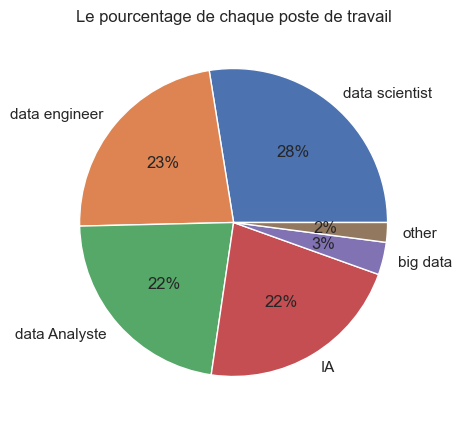

In [144]:
Total_job = Analyse_df['job role'].value_counts()

labels = Total_job.index
sizes = Total_job.values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.0f%%')

# Add a title to the pie chart
ax.set_title('Le pourcentage de chaque poste de travail')

plt.show()

##### Top 10 Company :

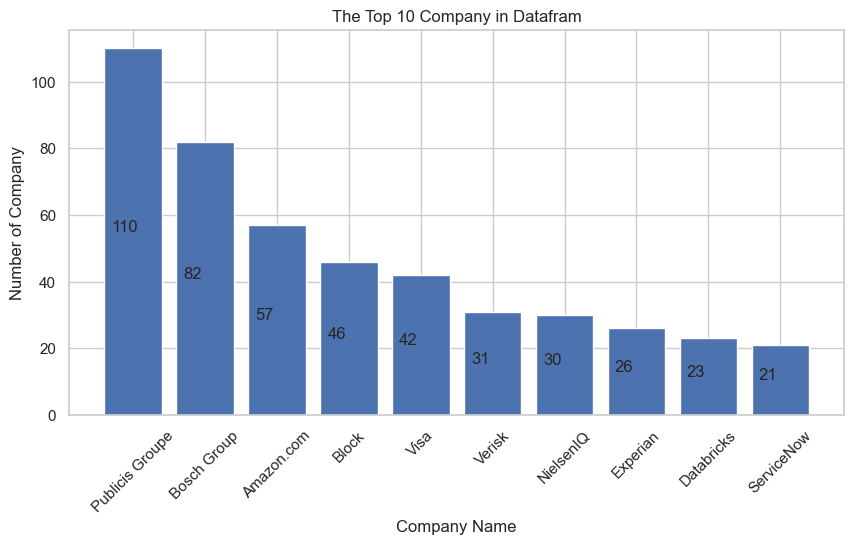

In [145]:
Top_company = Analyse_df['Company'].value_counts()[:10]

fig, ax = plt.subplots()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown', 'gray', 'cyan']

# Create the bar chart with colors :

bars = ax.bar(Top_company.index, Top_company.values)

# Add values to the bar chart

for i, v in enumerate(Top_company.values):
    ax.text(i - 0.3, v/2, str(v))


ax.set_ylabel('Number of Company')
ax.set_xlabel('Company Name')
ax.set_title('The Top 10 Company in Datafram')


plt.xticks(rotation=45)
plt.show()

## Country :

#####  Les 10 pays offrant l'emplois :

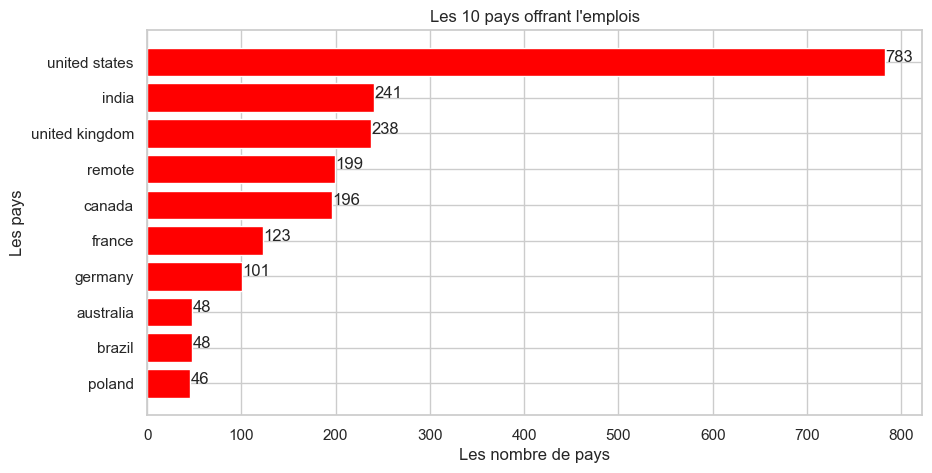

In [146]:
Top_Country = Analyse_df['Country'].value_counts()[:10]
Top_Country = Top_Country.sort_values(ascending=True)
Top_Country

# Sample data (replace with your actual data) :
categories = Top_Country.index
values = Top_Country.values

# Create a figure and axis :
fig, ax = plt.subplots()

# Create the bar chart :
ax.barh(categories, values,color='red')
# add value of nomber pays in bar :

for i, v in enumerate(values):
    ax.text(v , i, str(v))

# Add labels and title :
ax.set_xlabel('Les nombre de pays')
ax.set_ylabel('Les pays')
ax.set_title('Les 10 pays offrant l\'emplois')

# Show the plot
plt.show()


##### Les Postes de Travail avec le Plus Grand Nombre d'Offres dans Chaque Pays :

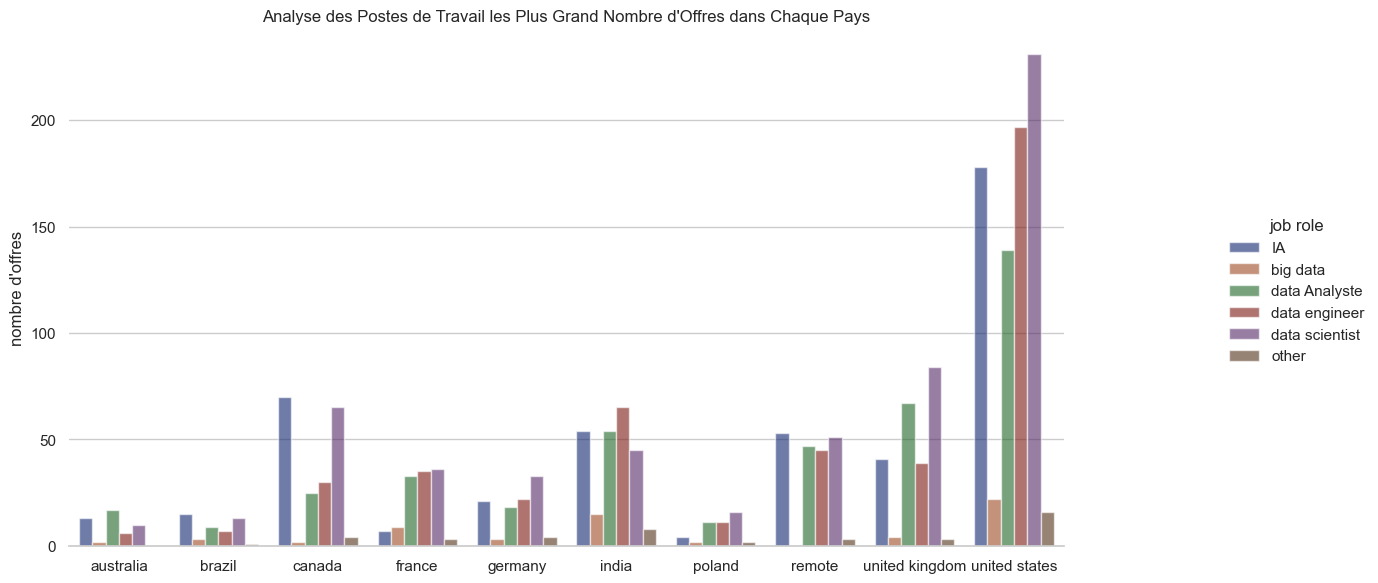

In [147]:
# get the data :
filtered_df = Analyse_df[Analyse_df['Country'].isin(Top_Country.index)]
job_role_counts = filtered_df.groupby(['Country', 'job role']).size().reset_index(name='count')

# show graph of data :
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=job_role_counts, kind="bar",
    x="Country", y="count", hue="job role",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.figure.set_size_inches(15, 6)

g.despine(left=True)
g.set_axis_labels("", "nombre d'offres")
plt.title("Analyse des Postes de Travail les Plus Grand Nombre d'Offres dans Chaque Pays")
plt.show()

## Post de traveille  :

##### Number Experience level dans chaque post :

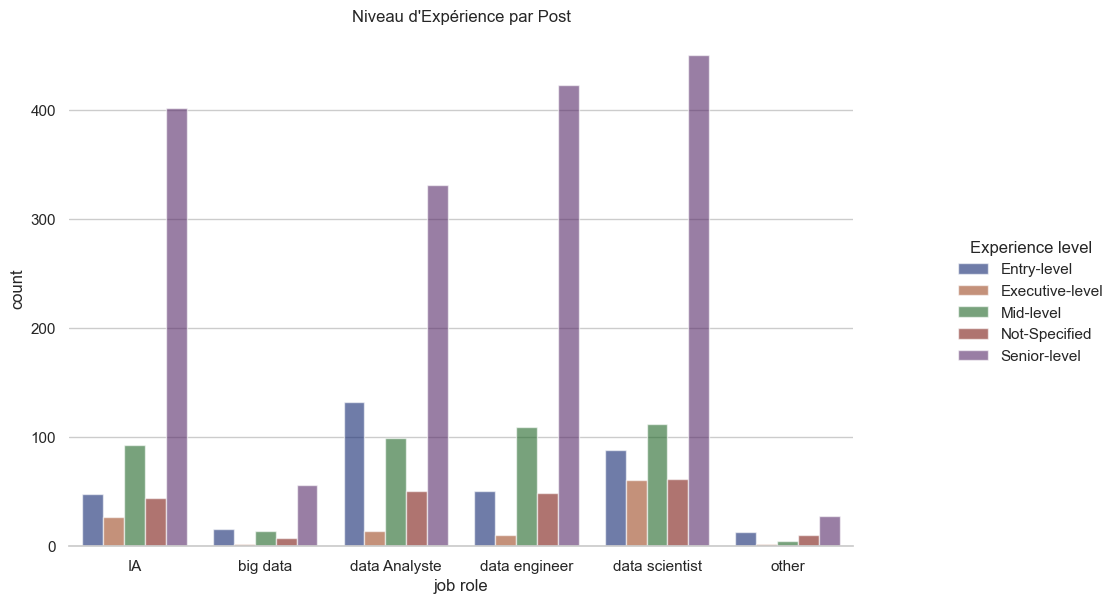

In [148]:
exp_level_counts = Analyse_df[Analyse_df['Experience level'] != 'No info ']
exp_level_counts

exp_level_counts = exp_level_counts.groupby(['job role','Experience level']).size().reset_index(name='count')

g = sns.catplot(
    data=exp_level_counts, kind="bar",
    x="job role", y="count", hue="Experience level",
    errorbar="sd", palette="dark", alpha=.6, height=6
)

g.figure.set_size_inches(12, 6)

g.despine(left=True)
plt.title("Niveau d'Expérience par Post")
plt.show()

##### Quel est Le grand offres d'emploi à distance par chaque Post :

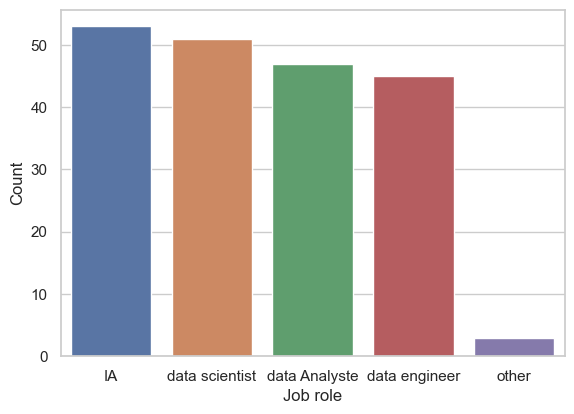

In [149]:
top_remote_post = Analyse_df[Analyse_df['Country'] == 'remote'][['job role','Country']].groupby('job role')['Country'].count()
top_remote_post = top_remote_post.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6.5, 4.5))
sns.barplot(x=top_remote_post.index, y=top_remote_post.values)
ax.set_xticklabels(top_remote_post.index)
ax.set_xlabel('Job role')
ax.set_ylabel('Count')
plt.show()


## Salary :

#### le moyan salaire de chaque pay :

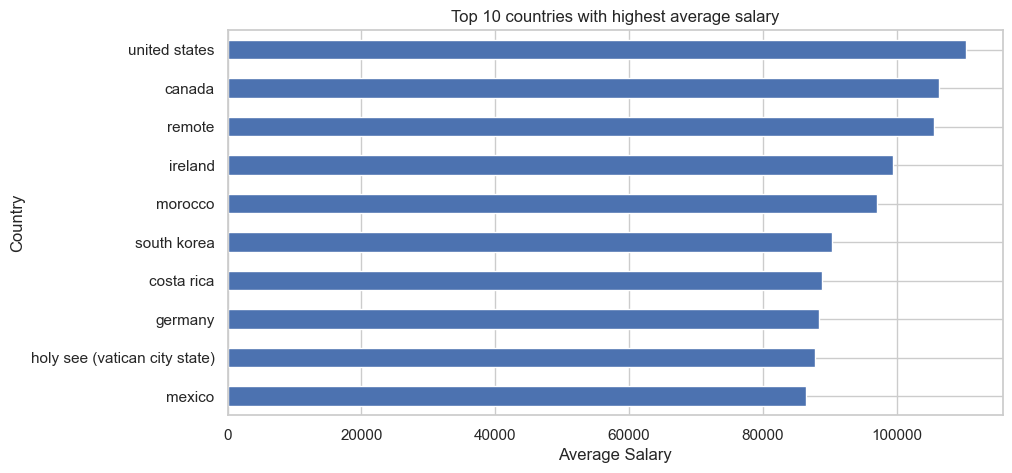

In [150]:
# country has count greater than  : 

country_counts = Analyse_df['Country'].value_counts()

countries_greater_than_3 = country_counts[country_counts > 10]

Filtered_df = Analyse_df[Analyse_df['Country'].isin(countries_greater_than_3.index)]

# get the average salary for each country  :
Filtered_df = Filtered_df.groupby('Country')['AVG_Salary'].mean().nlargest(10)

# create bar graph  :
Filtered_df.plot(kind = 'barh', figsize = (10, 5)).invert_yaxis()

# add figure labels :
plt.xlabel('Average Salary')
plt.ylabel('Country')
plt.title('Top 10 countries with highest average salary')
plt.show()

##### Top salaire dans chaque post :

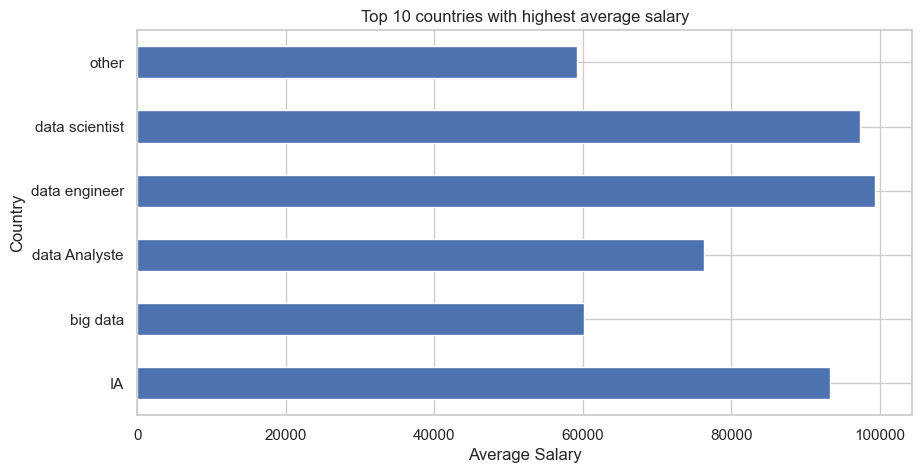

In [151]:
Analyse_df.groupby('job role')['AVG_Salary'].mean()

# create bar graph  :
Analyse_df.groupby('job role')['AVG_Salary'].mean().plot(kind = 'barh', figsize = (10, 5))

# add figure labels :
plt.xlabel('Average Salary')
plt.ylabel('Country')
plt.title('Top 10 countries with highest average salary')
plt.show()

#### Distribution des salaires par poste de travail. :

Text(0, 0.5, 'salaire')

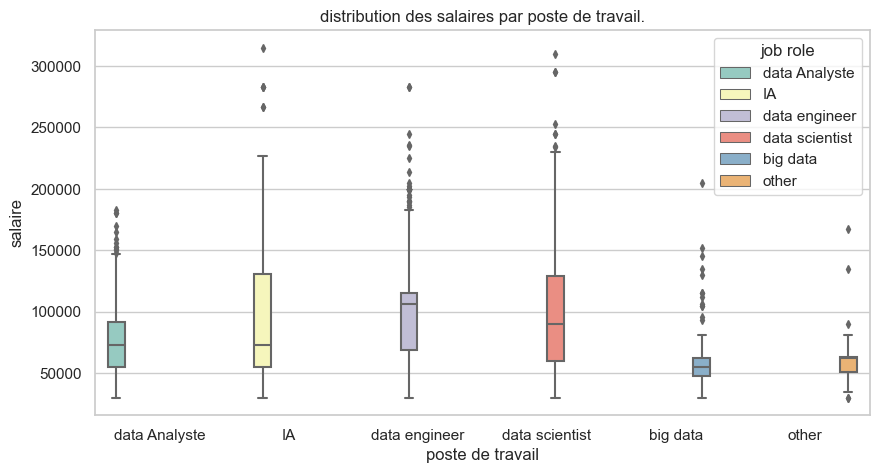

In [152]:
salary_of_job_role = Analyse_df[Analyse_df['AVG_Salary'] != 0]

sns.boxplot(x="job role", y='AVG_Salary', hue="job role", data=salary_of_job_role, palette="Set3", linewidth=1.5, fliersize=4)

# add figure size to plot area plot :
# title :
plt.rcParams["figure.figsize"] = (10,5)
# add title :
plt.title("distribution des salaires par poste de travail.")
# add label :
plt.xlabel("poste de travail")
plt.ylabel("salaire")


## Job requirment :

##### Les top 5 Job requirment dans chaque post de traveille :

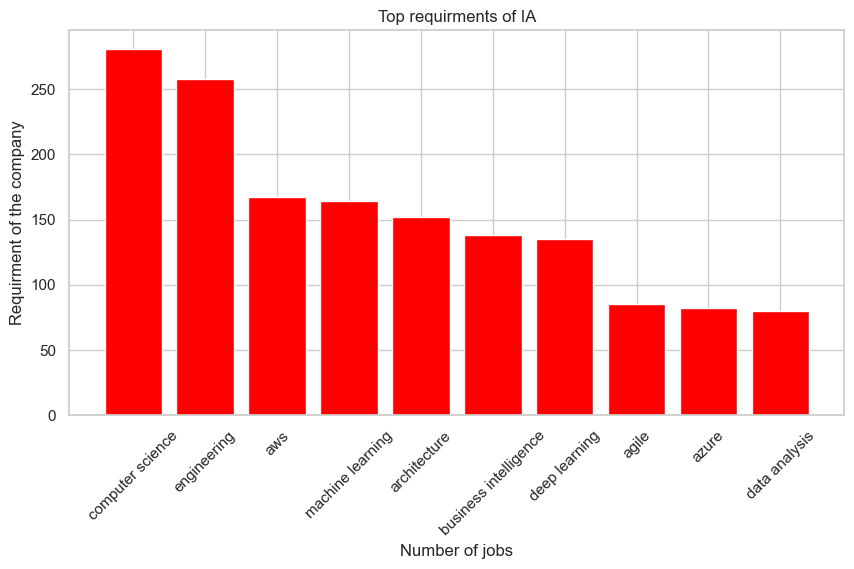

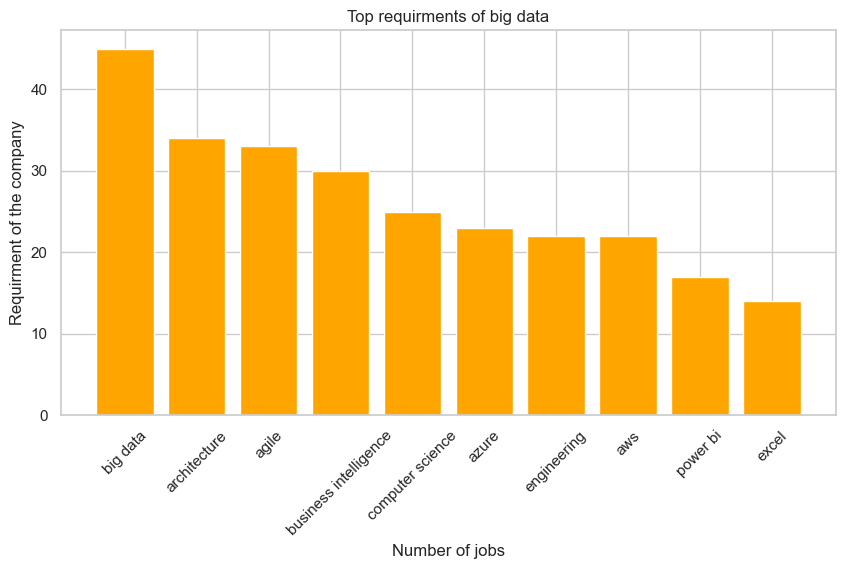

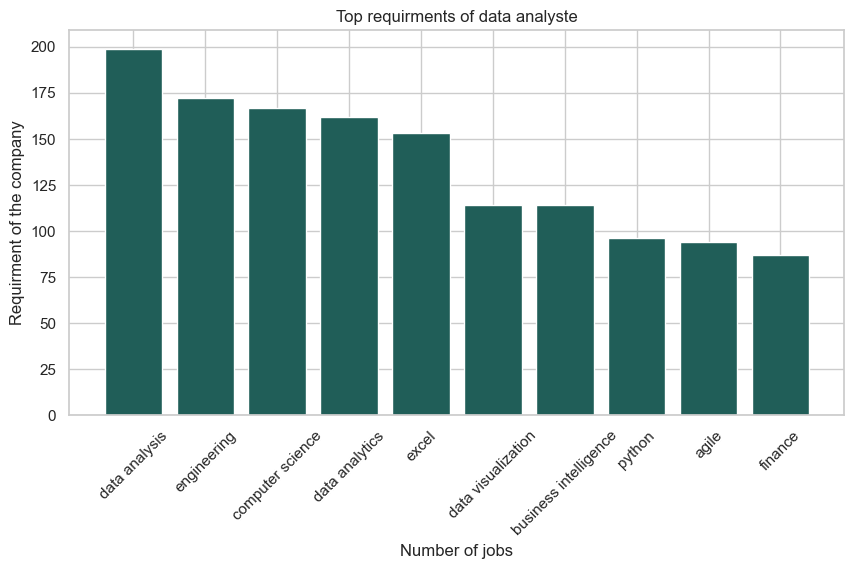

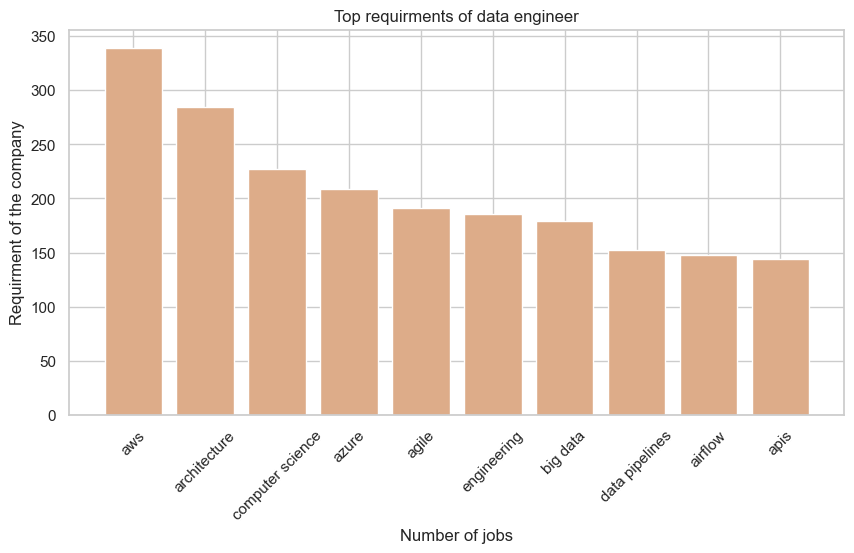

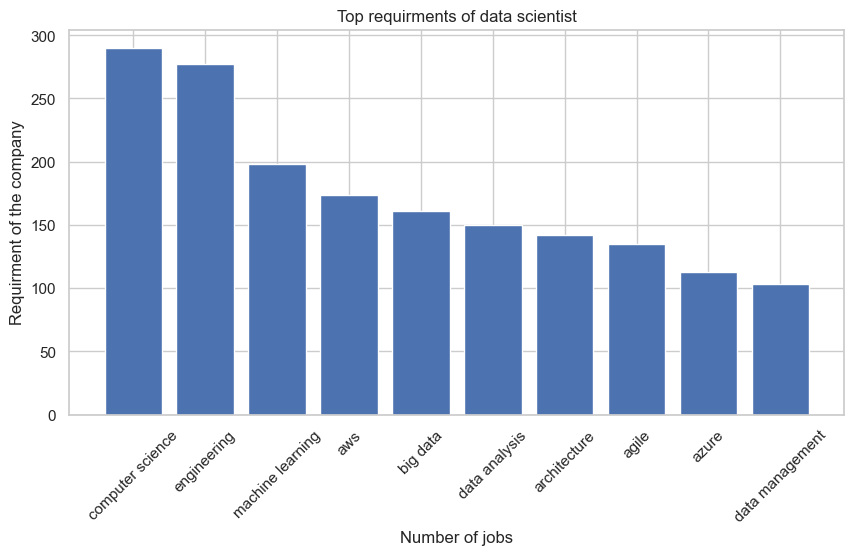

In [153]:
# get the each job role : 
job_requirment_ia = Analyse_df[Analyse_df['job role'] == 'IA']['Requirment of the company ']
job_requirment_big_data = Analyse_df[Analyse_df['job role'] == 'big data']['Requirment of the company ']
job_requirment_data_Analyste = Analyse_df[Analyse_df['job role'] == 'data Analyste']['Requirment of the company ']
job_requirment_data_engineer = Analyse_df[Analyse_df['job role'] == 'data engineer']['Requirment of the company ']
job_requirment_data_scientist = Analyse_df[Analyse_df['job role'] == 'data scientist']['Requirment of the company ']

# change the requirment column to list :
job_requirment_ia = [item for sublist in job_requirment_ia.tolist() for item in sublist]
job_requirment_big_data = [item for sublist in job_requirment_big_data.tolist() for item in sublist]
job_requirment_data_Analyste = [item for sublist in job_requirment_data_Analyste.tolist() for item in sublist]
job_requirment_data_engineer = [item for sublist in job_requirment_data_engineer.tolist() for item in sublist]
job_requirment_data_scientist = [item for sublist in job_requirment_data_scientist.tolist() for item in sublist]

def get_top_requirment(list_df) :
    # change to data frame :
    list_df = pd.Series(list_df)

    # delete values that are emtyed :
    list_df = list_df[list_df!= '']
    return list_df.value_counts().nlargest(10)

all_bar_graph = [get_top_requirment(job_requirment_ia),
get_top_requirment(job_requirment_big_data),
get_top_requirment(job_requirment_data_Analyste),
get_top_requirment(job_requirment_data_engineer),
get_top_requirment(job_requirment_data_scientist)]

# top requirements graph of ia :
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Top requirments of IA')
ax.set_xlabel('Number of jobs')
ax.set_ylabel('Requirment of the company')
ax.bar(all_bar_graph[0].index, all_bar_graph[0],color=['red'])
plt.xticks(rotation=45)
plt.show()

# top requirements graph of big data :
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Top requirments of big data')
ax.set_xlabel('Number of jobs')
ax.set_ylabel('Requirment of the company')
ax.bar(all_bar_graph[1].index, all_bar_graph[1],color=['orange'])
plt.xticks(rotation=45)
plt.show()

# top requirements graph of data analyste :
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Top requirments of data analyste')
ax.set_xlabel('Number of jobs')
ax.set_ylabel('Requirment of the company')
ax.bar(all_bar_graph[2].index, all_bar_graph[2],color='#205E58')
plt.xticks(rotation=45)
plt.show()

# top requirements graph of data engineer :
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Top requirments of data engineer')
ax.set_xlabel('Number of jobs')
ax.set_ylabel('Requirment of the company')
ax.bar(all_bar_graph[3].index, all_bar_graph[3],color='#ddac89')
plt.xticks(rotation=45)
plt.show()

# top requirements graph of data scientist :
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Top requirments of data scientist')
ax.set_xlabel('Number of jobs')
ax.set_ylabel('Requirment of the company')
ax.bar(all_bar_graph[4].index, all_bar_graph[4])
plt.xticks(rotation=45)
plt.show()

## Job Type :

##### le 10 Meilleure Paye Par Job Type :

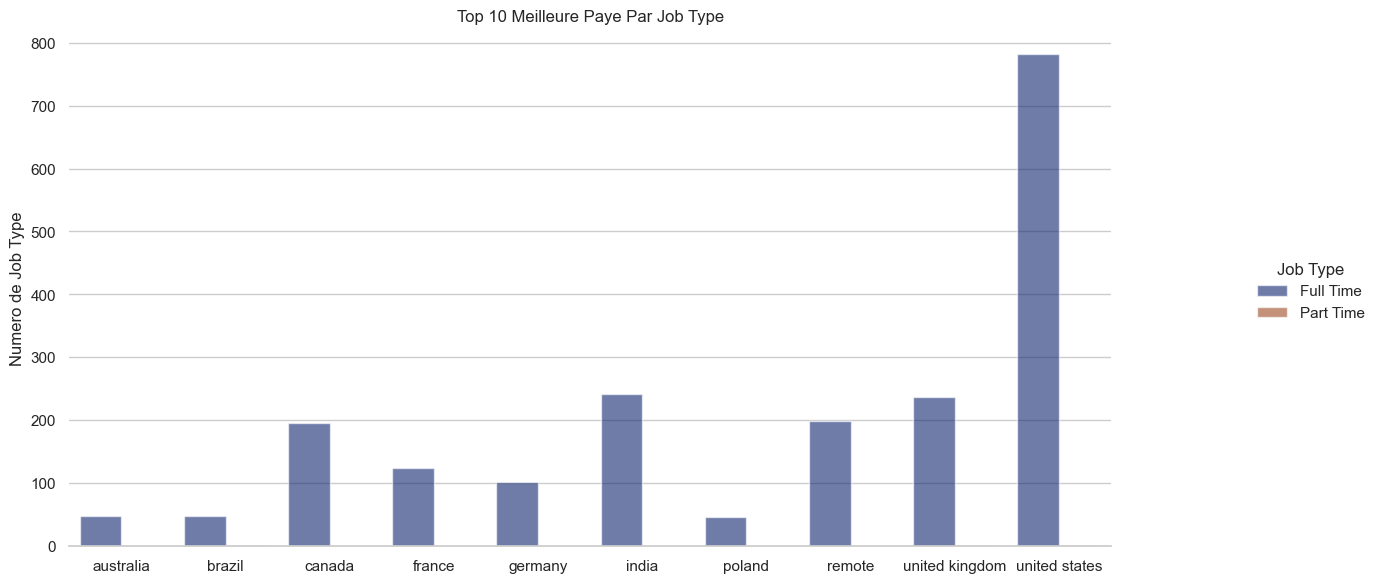

In [154]:
# get the data :
job_type_by_country = filtered_df.groupby(['Country', 'Job Type']).size().reset_index(name='count')
job_type_by_country

# show graph of data :
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=job_type_by_country, kind="bar",
    x="Country", y="count", hue="Job Type",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.figure.set_size_inches(15, 6)

g.despine(left=True)
g.set_axis_labels("", "Numero de Job Type")
plt.title("Top 10 Meilleure Paye Par Job Type")
plt.show()

##### Job Type dans chaque post :

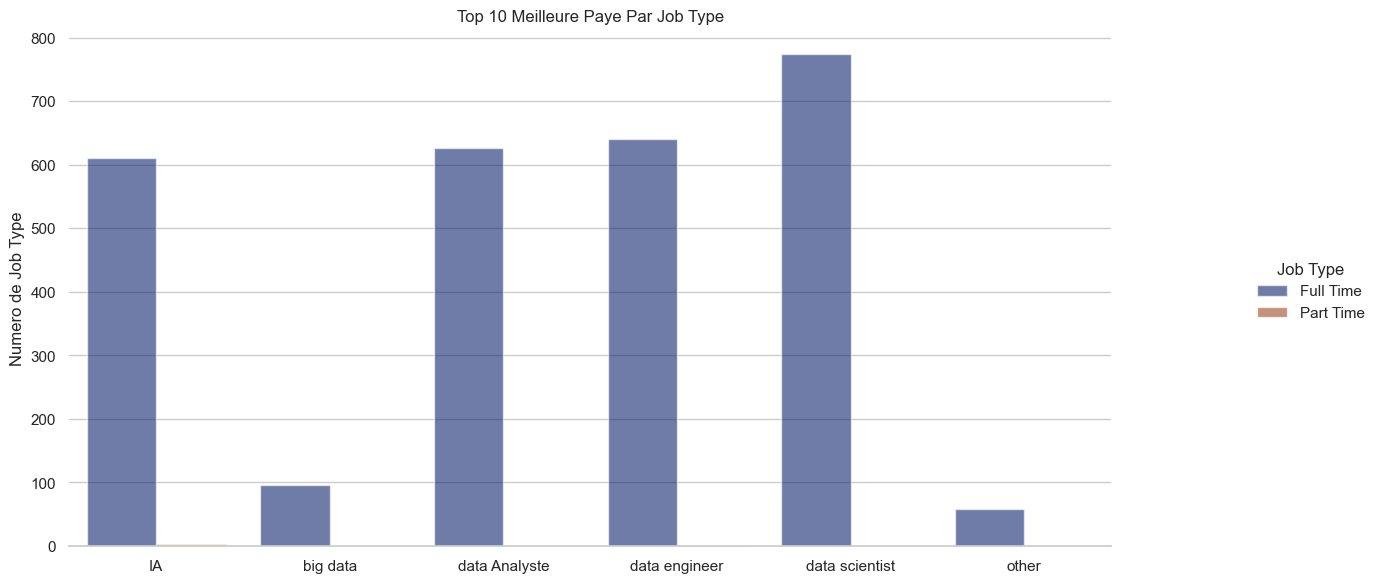

In [155]:
job_type_by_job_role = Analyse_df.groupby(['job role','Job Type']).size().reset_index(name='count')
job_type_by_job_role

# show graph of data :
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=job_type_by_job_role, kind="bar",
    x="job role", y="count", hue="Job Type",
    errorbar="sd", palette="dark", alpha=.6, height=6
)

g.figure.set_size_inches(15, 6)
g.despine(left=True)
g.set_axis_labels("", "Numero de Job Type")
plt.title("Top 10 Meilleure Paye Par Job Type")
plt.show()

## Facilities :

In [156]:
# fixe the type of facilities :
def str_to_list(text) :
    if type(text) == str :
        if text != "No Facilities" :
            return text.split(",")
        else :
            return text
    else :
        return text

Analyse_df["Facilities"] = Analyse_df["Facilities"].apply(str_to_list)

##### Les Facilities les plus couramment offerts par les post :

#### IA :

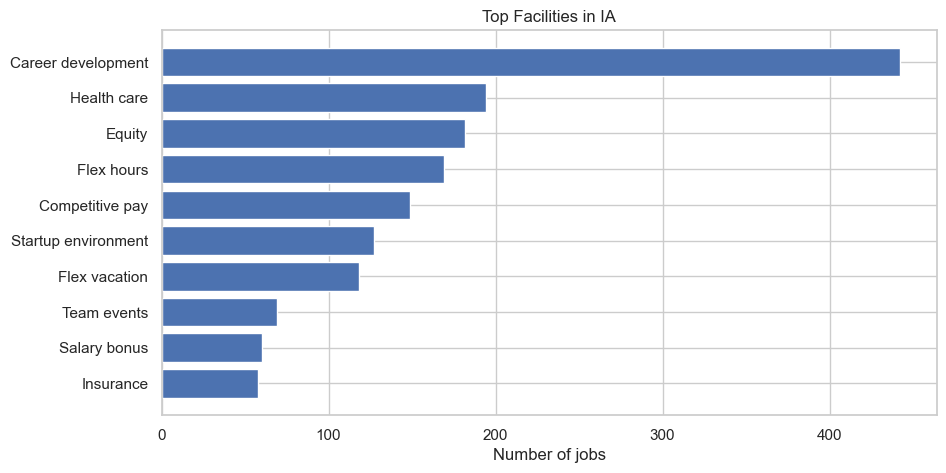

In [157]:
# Facilities of IA :
ia_df = Analyse_df[Analyse_df["job role"] == 'IA']
Facilities_ia = ia_df[ia_df["Facilities"] != "No Facilities"]["Facilities"].tolist()
Facilities_ia = [item for sublist in Facilities_ia for item in sublist]
# Top Facilities in IA  :
Facilities_ia_df = pd.Series(Facilities_ia)
Top_fac_ia = Facilities_ia_df.value_counts().nlargest(10)

# graph of Top Facilities in IA  :
fig, ax = plt.subplots(figsize=(10,5))
ax.barh(Top_fac_ia.index, Top_fac_ia.values)
ax.set_yticks(Top_fac_ia.index)
ax.set_yticklabels(Top_fac_ia.index)
ax.invert_yaxis()
ax.set_xlabel("Number of jobs")
ax.set_title("Top Facilities in IA")
plt.show()


#### big data :

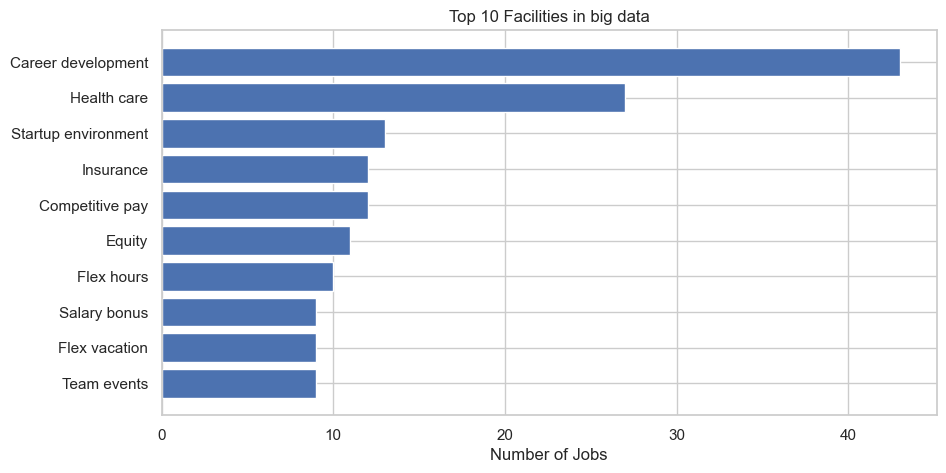

In [158]:
# Facilities of big data :
bigdata_df = Analyse_df[Analyse_df["job role"] == 'big data']
Facilities_bigdata = bigdata_df[bigdata_df["Facilities"]!= "No Facilities"]["Facilities"].tolist()
Facilities_bigdata = [item for sublist in Facilities_bigdata for item in sublist]
# Top Facilities in big data :
Facilities_bigdata_df = pd.Series(Facilities_bigdata)
Top_fac_bigdata = Facilities_bigdata_df.value_counts().nlargest(10)

# graph of Top Facilities in big data :
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(Top_fac_bigdata.index, Top_fac_bigdata.values)
ax.invert_yaxis()
ax.set_yticks(Top_fac_bigdata.index)
ax.set_yticklabels(Top_fac_bigdata.index)
ax.set_xlabel("Number of Jobs")
ax.set_title("Top 10 Facilities in big data")
plt.show()

#### data Analyste :

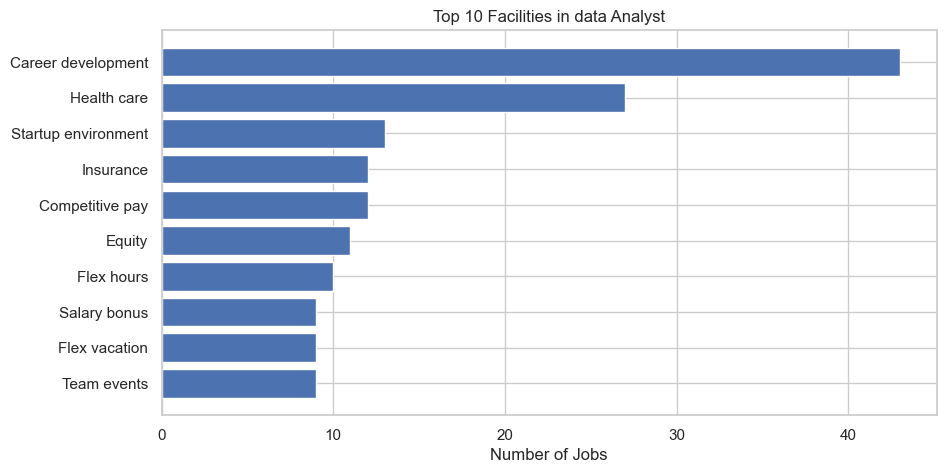

In [159]:
# Facilities of data Analyste :
dataanalyst_df = Analyse_df[Analyse_df["job role"] == 'data Analyste']
Facilities_dataanalyst = dataanalyst_df[dataanalyst_df["Facilities"]!= "No Facilities"]["Facilities"].tolist()
Facilities_dataanalyst = [item for sublist in Facilities_dataanalyst for item in sublist]
# Top Facilities in data analyst :
Facilities_dataanalyst_df = pd.Series(Facilities_dataanalyst)
Top_fac_dataanalyst = Facilities_dataanalyst_df.value_counts().nlargest(10)
Top_fac_dataanalyst

# graph of Top Facilities in data Analyst :
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(Top_fac_bigdata.index, Top_fac_bigdata.values)
ax.invert_yaxis()
ax.set_yticks(Top_fac_bigdata.index)
ax.set_yticklabels(Top_fac_bigdata.index)
ax.set_xlabel("Number of Jobs")
ax.set_title("Top 10 Facilities in data Analyst")
plt.show()

#### data engineer :

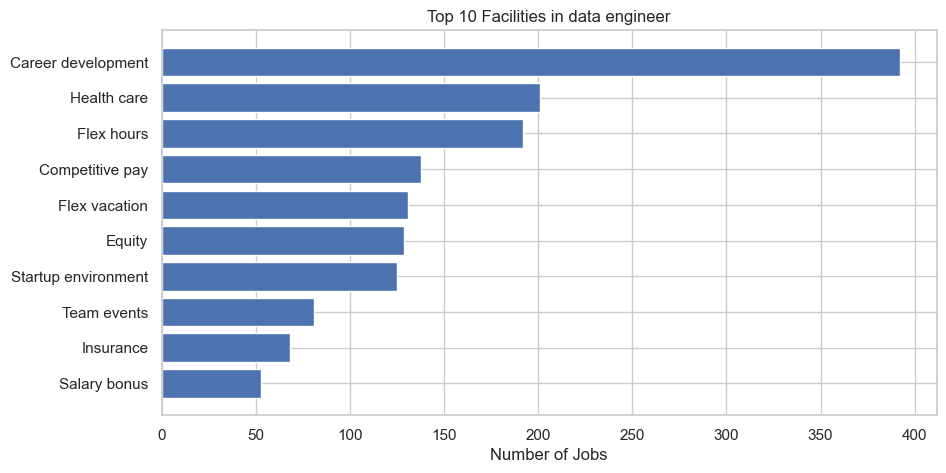

In [160]:
# Facilities of data engineer :
dataengineer_df = Analyse_df[Analyse_df["job role"] == 'data engineer']
Facilities_dataengineer = dataengineer_df[dataengineer_df["Facilities"]!= "No Facilities"]["Facilities"].tolist()
Facilities_dataengineer = [item for sublist in Facilities_dataengineer for item in sublist]
# Top Facilities in data engineer :
Facilities_dataengineer_df = pd.Series(Facilities_dataengineer)
Top_fac_dataengineer = Facilities_dataengineer_df.value_counts().nlargest(10)

# graph of Top Facilities in data engineer :
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(Top_fac_dataengineer.index, Top_fac_dataengineer.values)
ax.invert_yaxis()
ax.set_yticks(Top_fac_dataengineer.index)
ax.set_yticklabels(Top_fac_dataengineer.index)
ax.set_xlabel("Number of Jobs")
ax.set_title("Top 10 Facilities in data engineer")
plt.show()

#### data scientist :

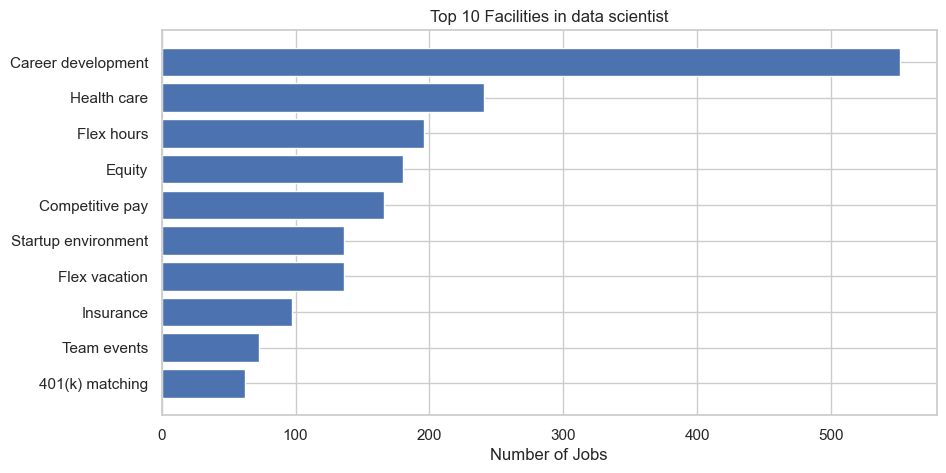

In [161]:
# Facilities of data scientist :
datasci_df = Analyse_df[Analyse_df["job role"] == 'data scientist']
Facilities_datasci = datasci_df[datasci_df["Facilities"]!= "No Facilities"]["Facilities"].tolist()
Facilities_datasci = [item for sublist in Facilities_datasci for item in sublist]
# Top Facilities in data scientist :
Facilities_datasci_df = pd.Series(Facilities_datasci)
Top_fac_datasci = Facilities_datasci_df.value_counts().nlargest(10)

# graph of Top Facilities in data scientist :
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(Top_fac_datasci.index, Top_fac_datasci.values)
ax.invert_yaxis()
ax.set_yticks(Top_fac_datasci.index)
ax.set_yticklabels(Top_fac_datasci.index)
ax.set_xlabel("Number of Jobs")
ax.set_title("Top 10 Facilities in data scientist")
plt.show()

#### Export datframe to insert :

In [162]:
# save Analyse_df to csv :
Analyse_df.to_csv('for_isertion_df.csv',index=False)